In [47]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics

In [48]:
from notebook_utils import *

In [49]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [50]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..


In [51]:
def get_datasets(selector, task_type, suite='openml'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

# Setting params

In [52]:
eval_positions = [1000]
max_features = 100
bptt = 2000
selector = 'test'
base_path = os.path.join('.')
overwrite=False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
max_times = [0.5]
metric_used = tabular_metrics.auc_metric
#methods = ['transformer', 'logistic', 'gp', 'knn', 'catboost', 'xgb', 'autosklearn2', 'autogluon']
methods = ['transformer', 'logistic']
task_type = 'multiclass'

In [53]:
suite = 'cc'
test_datasets = get_datasets('test',task_type, suite=suite)

In [54]:
clf_dict= {'gp': gp_metric
                , 'knn': knn_metric
                , 'catboost': catboost_metric
                , 'xgb': xgb_metric
           , 'transformer': transformer_metric
                , 'logistic': logistic_metric
           , 'autosklearn': autosklearn_metric
             , 'autosklearn2': autosklearn2_metric
            , 'autogluon': autogluon_metric}

In [85]:
device = 'cpu'

def eval_method(task_type, method, dids, selector, eval_positions, max_time, metric_used, split_number, append_metric=True, fetch_only=False, verbose=False):
    
    dids = dids if type(dids) is list else [dids]
    print('dids')
    print(dids)
    
    for did in dids:

        ds = get_datasets(selector, task_type, suite=suite)

        ds = ds if did is None else ds[did:did+1]

        clf = clf_dict[method]

        time_string = '_time_'+str(max_time) if max_time else ''
        metric_used_string = '_'+tabular_baselines.get_scoring_string(metric_used, usage='') if append_metric else ''

        result = evaluate(datasets=ds
                          , model=clf
                          , method=method+time_string+metric_used_string
                          , bptt=bptt, base_path=base_path
                          , eval_positions=eval_positions
                          , device=device, max_splits=1
                          , overwrite=overwrite
                          , save=True
                          , metric_used=metric_used
                          , path_interfix=task_type
                          , fetch_only=fetch_only
                          , split_number=split_number
                          , verbose=verbose
                          , max_time=max_time)
    
    return result

# Baseline Evaluation
This section runs baselines and saves results locally.

In [56]:
!mkdir {base_path}/results
!mkdir {base_path}/results/tabular/
!mkdir {base_path}/results/tabular/multiclass/

mkdir: ./results: File exists
mkdir: ./results/tabular/: File exists
mkdir: ./results/tabular/multiclass/: File exists


In [57]:
# RUN ONE METHOD ON ONE DATASET AND SPLIT
overwrite=True
dataset_id = 0
split_number = 1
maximum_runtime = 30
r = eval_method(task_type, 'transformer', dataset_id, 'test', eval_positions, maximum_runtime, metric_used, split_number)

Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:02<?, ?it/s]

saved results to ./results/tabular/multiclass/results_transformer_time_30_roc_auc_balance-scale_312_624_1.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [58]:
# RUN ALL METHODS, SPLITS AND DATASETS
test_datasets = get_datasets('test',task_type, suite=suite)

overwrite=True
jobs = [
    eval_method(task_type, m, did, selector, eval_positions, max_time, metric_used, split_number)
    for did in range(0, len(test_datasets))
    for selector in ['test']
    for m in methods
    for max_time in max_times
    for split_number in [1, 2, 3, 4, 5]
]

Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_balance-scale_312_624_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_balance-scale_312_624_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_balance-scale_312_624_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_balance-scale_312_624_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_balance-scale_312_624_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:16,  2.01trial/s, best loss: -0.9491881651766712]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_balance-scale_312_624_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<02:39,  6.24trial/s, best loss: -0.9618780366387891]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_balance-scale_312_624_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 6/1000 [00:00<01:23, 11.92trial/s, best loss: -0.9553645833333334]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_balance-scale_312_624_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<02:11,  7.57trial/s, best loss: -0.9734017515051999]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_balance-scale_312_624_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 312:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:00<00:59, 16.76trial/s, best loss: -0.9538681989721415]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_balance-scale_312_624_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-fourier_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-fourier_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-fourier_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-fourier_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-fourier_1000_2000_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:02<47:14,  2.84s/trial, best loss: -0.9709936075951651]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-fourier_1000_2000_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:05<1:25:06,  5.11s/trial, best loss: -0.9724842576926882]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-fourier_1000_2000_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:04<1:14:58,  4.50s/trial, best loss: -0.9633579276559029]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-fourier_1000_2000_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:08<2:15:37,  8.15s/trial, best loss: -0.9713950550102928]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:10<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-fourier_1000_2000_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:05<1:34:55,  5.70s/trial, best loss: -0.9717386152140328]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-fourier_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_breast-w_349_698_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_breast-w_349_698_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_breast-w_349_698_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_breast-w_349_698_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_breast-w_349_698_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 9/1000 [00:00<00:52, 18.77trial/s, best loss: -0.9943840579710145]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_breast-w_349_698_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 10/1000 [00:00<00:57, 17.29trial/s, best loss: -0.9973495360636896]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_breast-w_349_698_2.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 8/1000 [00:00<00:58, 17.09trial/s, best loss: -0.9920973602005658]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_breast-w_349_698_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 8/1000 [00:00<01:06, 14.97trial/s, best loss: -0.9961917977181622]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_breast-w_349_698_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 349:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 9/1000 [00:00<00:56, 17.59trial/s, best loss: -0.9944720401131535]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_breast-w_349_698_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-karhunen_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-karhunen_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-karhunen_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-karhunen_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-karhunen_1000_2000_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:02<42:06,  2.53s/trial, best loss: -0.9951669933496928]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-karhunen_1000_2000_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:04<1:10:56,  4.26s/trial, best loss: -0.9981403027787057]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-karhunen_1000_2000_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:03<1:05:45,  3.95s/trial, best loss: -0.9975454312098101]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-karhunen_1000_2000_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:07<1:57:30,  7.06s/trial, best loss: -0.9972989017187409]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:10<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-karhunen_1000_2000_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:04<1:20:44,  4.85s/trial, best loss: -0.9965496127370181]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-karhunen_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-morphological_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-morphological_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-morphological_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-morphological_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:12<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-morphological_1000_2000_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<13:16,  1.25trial/s, best loss: -0.9667676291365682]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:01<?, ?it/s]


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-morphological_1000_2000_1.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<16:34,  1.00trial/s, best loss: -0.9650375588642245]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-morphological_1000_2000_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<14:58,  1.11trial/s, best loss: -0.9637680920734757]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-morphological_1000_2000_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<17:40,  1.06s/trial, best loss: -0.9657038078094404]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-morphological_1000_2000_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:01<19:13,  1.15s/trial, best loss: -0.964971507433134]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-morphological_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-zernike_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-zernike_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-zernike_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-zernike_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_mfeat-zernike_1000_2000_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<29:59,  1.80s/trial, best loss: -0.9792290762799837]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-zernike_1000_2000_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:03<55:02,  3.31s/trial, best loss: -0.9820386475632248]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-zernike_1000_2000_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:03<51:26,  3.09s/trial, best loss: -0.9805385004446572]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-zernike_1000_2000_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:05<1:23:16,  5.00s/trial, best loss: -0.9773659955786785]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-zernike_1000_2000_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWar

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:03<1:01:31,  3.70s/trial, best loss: -0.9786397156998046]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 1000:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_mfeat-zernike_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cmc_736_1472_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cmc_736_1472_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cmc_736_1472_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cmc_736_1472_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 736:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cmc_736_1472_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<02:44,  6.05trial/s, best loss: -0.6986213952470524]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cmc_736_1472_1.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<01:34, 10.50trial/s, best loss: -0.6656384114753903]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cmc_736_1472_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<02:12,  7.53trial/s, best loss: -0.7204890177073897]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cmc_736_1472_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<02:43,  6.10trial/s, best loss: -0.715290645406361]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cmc_736_1472_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<02:39,  6.27trial/s, best loss: -0.6908014232582426]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 736:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cmc_736_1472_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-approval_345_690_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-approval_345_690_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-approval_345_690_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-approval_345_690_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 345:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-approval_345_690_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<02:17,  7.23trial/s, best loss: -0.8991457366457366]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-approval_345_690_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<02:40,  6.20trial/s, best loss: -0.9136315030637991]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-approval_345_690_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<03:24,  4.88trial/s, best loss: -0.9197037947037947]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-approval_345_690_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 3/1000 [00:00<02:20,  7.08trial/s, best loss: -0.9094929712843927]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-approval_345_690_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 5/1000 [00:00<01:26, 11.51trial/s, best loss: -0.9316121426466253]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 345:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-approval_345_690_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-g_500_1000_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-g_500_1000_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-g_500_1000_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-g_500_1000_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 500:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_credit-g_500_1000_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<07:28,  2.22trial/s, best loss: -0.759049935717625]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-g_500_1000_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

  0%|          | 2/1000 [00:00<03:10,  5.24trial/s, best loss: -0.7649267347892874]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-g_500_1000_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<01:33, 10.69trial/s, best loss: -0.769039154467032]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-g_500_1000_3.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_mo

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<04:46,  3.48trial/s, best loss: -0.7654339143792159]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-g_500_1000_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<02:36,  6.35trial/s, best loss: -0.7572420634920636]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 500:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_credit-g_500_1000_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_diabetes_384_768_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_diabetes_384_768_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_diabetes_384_768_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_diabetes_384_768_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 384:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_diabetes_384_768_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 16/1000 [00:00<00:30, 32.69trial/s, best loss: -0.8360120937263794]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_diabetes_384_768_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 15/1000 [00:00<00:30, 32.20trial/s, best loss: -0.8161186525892408]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_diabetes_384_768_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 14/1000 [00:00<00:36, 27.01trial/s, best loss: -0.7981852931648851]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_diabetes_384_768_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 17/1000 [00:00<00:27, 36.01trial/s, best loss: -0.8274558283904694]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_diabetes_384_768_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 15/1000 [00:00<00:29, 33.36trial/s, best loss: -0.7849711694201489]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 384:   0%|          | 0/1 [00:00<?, ?it/s]


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_diabetes_384_768_5.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_tic-tac-toe_479_958_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_tic-tac-toe_479_958_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_tic-tac-toe_479_958_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_tic-tac-toe_479_958_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_tic-tac-toe_479_958_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 5/1000 [00:00<01:42,  9.69trial/s, best loss: -0.998215095766129]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_tic-tac-toe_479_958_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 6/1000 [00:00<01:30, 11.04trial/s, best loss: -0.9942529513497256]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_tic-tac-toe_479_958_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 5/1000 [00:00<02:12,  7.53trial/s, best loss: -0.9965277777777779]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_tic-tac-toe_479_958_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<02:07,  7.79trial/s, best loss: -0.9970118156792804]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_tic-tac-toe_479_958_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<06:11,  2.69trial/s, best loss: -0.9911605885154273]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 479:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_tic-tac-toe_479_958_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_vehicle_423_846_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_vehicle_423_846_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_vehicle_423_846_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_vehicle_423_846_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 423:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_vehicle_423_846_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<03:10,  5.23trial/s, best loss: -0.93704851789663]  

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_vehicle_423_846_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<05:26,  3.05trial/s, best loss: -0.9319399929135731]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_vehicle_423_846_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<03:49,  4.34trial/s, best loss: -0.941477639724393]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_vehicle_423_846_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<08:09,  2.04trial/s, best loss: -0.9318004094407776]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_vehicle_423_846_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<05:26,  3.06trial/s, best loss: -0.9471431304385851]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 423:   0%|          | 0/1 [00:00<?, ?


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_vehicle_423_846_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_eucalyptus_368_736_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_eucalyptus_368_736_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_eucalyptus_368_736_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_eucalyptus_368_736_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 368:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_eucalyptus_368_736_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<03:29,  4.77trial/s, best loss: -0.8110294553488332]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_eucalyptus_368_736_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<10:51,  1.53trial/s, best loss: -0.8437920129484301]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_eucalyptus_368_736_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<24:38,  1.48s/trial, best loss: -0.8532706972718934]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_eucalyptus_368_736_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<04:09,  4.01trial/s, best loss: -0.7883635063805136]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_eucalyptus_368_736_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<01:32, 10.86trial/s, best loss: -0.5]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 368:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_eucalyptus_368_736_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_authorship_420_840_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_authorship_420_840_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_authorship_420_840_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_authorship_420_840_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 420:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_authorship_420_840_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<16:26,  1.01trial/s, best loss: -0.9999649859943979]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_authorship_420_840_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<14:37,  1.14trial/s, best loss: -0.9999258435298479]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_authorship_420_840_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<02:31,  6.57trial/s, best loss: -0.8734652901564666]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_authorship_420_840_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<08:20,  2.00trial/s, best loss: -0.999749523633905]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_authorship_420_840_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<23:14,  1.40s/trial, best loss: -1.0]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 420:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_authorship_420_840_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_dmft_398_796_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_dmft_398_796_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_dmft_398_796_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_dmft_398_796_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_analcatdata_dmft_398_796_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<03:24,  4.88trial/s, best loss: -0.5511523474134739]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_dmft_398_796_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<02:04,  8.00trial/s, best loss: -0.5728208110391367]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_dmft_398_796_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<04:41,  3.54trial/s, best loss: -0.5784060807426192]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_dmft_398_796_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<06:07,  2.72trial/s, best loss: -0.6199673574288959]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_dmft_398_796_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<06:07,  2.72trial/s, best loss: -0.5599741201597886]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 398:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_analcatdata_dmft_398_796_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc4_729_1458_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc4_729_1458_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc4_729_1458_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc4_729_1458_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 729:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc4_729_1458_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<02:40,  6.21trial/s, best loss: -0.8519436844505244]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc4_729_1458_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<10:09,  1.64trial/s, best loss: -0.9094555118559052]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc4_729_1458_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<08:17,  2.01trial/s, best loss: -0.9083569643942848]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc4_729_1458_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<03:32,  4.68trial/s, best loss: -0.8914818566066856]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc4_729_1458_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 729:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<01:44,  9.53trial/s, best loss: -0.9129166666666666]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc4_729_1458_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc3_781_1562_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc3_781_1562_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc3_781_1562_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc3_781_1562_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 781:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc3_781_1562_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<03:03,  5.43trial/s, best loss: -0.7790617848970252]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc3_781_1562_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<03:08,  5.31trial/s, best loss: -0.7506670168067228]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc3_781_1562_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<06:21,  2.62trial/s, best loss: -0.832109295845998]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc3_781_1562_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<07:15,  2.29trial/s, best loss: -0.7950110499835426]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc3_781_1562_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<02:18,  7.18trial/s, best loss: -0.7635607732301554]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 781:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc3_781_1562_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_kc2_261_522_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_kc2_261_522_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_kc2_261_522_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_kc2_261_522_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_kc2_261_522_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 12/1000 [00:00<00:41, 23.61trial/s, best loss: -0.8243634515890614]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_kc2_261_522_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 12/1000 [00:00<00:41, 23.63trial/s, best loss: -0.8625217110125647]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_kc2_261_522_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 8/1000 [00:00<01:07, 14.73trial/s, best loss: -0.917297895902547]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_kc2_261_522_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:19, 12.44trial/s, best loss: -0.8156493506493507]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_kc2_261_522_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<01:54,  8.68trial/s, best loss: -0.8542128603104213]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 261:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_kc2_261_522_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc1_554_1108_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc1_554_1108_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc1_554_1108_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc1_554_1108_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_pc1_554_1108_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<02:07,  7.78trial/s, best loss: -0.7962285287528006]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc1_554_1108_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<01:48,  9.22trial/s, best loss: -0.8045104510451045]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc1_554_1108_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 10/1000 [00:00<00:46, 21.27trial/s, best loss: -0.8435683760683761]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc1_554_1108_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:15, 13.17trial/s, best loss: -0.7968589743589743]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc1_554_1108_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 5/1000 [00:00<01:27, 11.41trial/s, best loss: -0.7981129307585618]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 554:   0%|          | 0/1 [00:00<?, ?


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_pc1_554_1108_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_banknote-authentication_686_1372_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_banknote-authentication_686_1372_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_banknote-authentication_686_1372_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_banknote-authentication_686_1372_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 686:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_banknote-authentication_686_1372_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 5/1000 [00:00<01:20, 12.33trial/s, best loss: -0.9996553944353215]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_banknote-authentication_686_1372_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 8/1000 [00:00<01:00, 16.39trial/s, best loss: -0.9996980155306299]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_banknote-authentication_686_1372_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 6/1000 [00:00<01:25, 11.64trial/s, best loss: -0.9994852913089215]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_banknote-authentication_686_1372_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 5/1000 [00:00<01:32, 10.80trial/s, best loss: -0.9996980155306299]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_banknote-authentication_686_1372_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:03, 15.58trial/s, best loss: -0.9997014994446503]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 686:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_banknote-authentication_686_1372_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_blood-transfusion-service-center_374_748_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_blood-transfusion-service-center_374_748_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_blood-transfusion-service-center_374_748_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_blood-transfusion-service-center_374_748_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 374:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_blood-transfusion-service-center_374_748_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 13/1000 [00:00<00:36, 26.96trial/s, best loss: -0.7443694777735758]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_blood-transfusion-service-center_374_748_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 13/1000 [00:00<00:34, 28.70trial/s, best loss: -0.7658080574435864]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_blood-transfusion-service-center_374_748_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 14/1000 [00:00<00:35, 28.06trial/s, best loss: -0.748463478958835]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_blood-transfusion-service-center_374_748_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 12/1000 [00:00<00:52, 18.72trial/s, best loss: -0.761127520175241]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_blood-transfusion-service-center_374_748_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 16/1000 [00:00<00:29, 33.50trial/s, best loss: -0.7469890002784739]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 374:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_blood-transfusion-service-center_374_748_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_ilpd_291_582_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_ilpd_291_582_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_ilpd_291_582_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_ilpd_291_582_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_ilpd_291_582_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 8/1000 [00:00<01:00, 16.39trial/s, best loss: -0.7704558652729385]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_ilpd_291_582_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:08, 14.41trial/s, best loss: -0.7209050693448111]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_ilpd_291_582_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:06, 14.96trial/s, best loss: -0.7178640642303433]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_ilpd_291_582_3.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 6/1000 [00:00<01:13, 13.53trial/s, best loss: -0.7367870985603545]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_ilpd_291_582_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 291:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 10/1000 [00:00<00:46, 21.36trial/s, best loss: -0.8173435769656701]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_ilpd_291_582_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_qsar-biodeg_527_1054_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_qsar-biodeg_527_1054_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:04<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_qsar-biodeg_527_1054_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_qsar-biodeg_527_1054_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 527:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_qsar-biodeg_527_1054_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<08:30,  1.96trial/s, best loss: -0.9106518282988871]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_qsar-biodeg_527_1054_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<05:29,  3.03trial/s, best loss: -0.9061451247165533]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_qsar-biodeg_527_1054_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<01:44,  9.52trial/s, best loss: -0.8937996647934536]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_qsar-biodeg_527_1054_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<03:56,  4.23trial/s, best loss: -0.9092701397049222]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_qsar-biodeg_527_1054_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<06:37,  2.51trial/s, best loss: -0.918459636106695]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 527:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_qsar-biodeg_527_1054_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_wdbc_284_568_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_wdbc_284_568_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_wdbc_284_568_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_wdbc_284_568_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_wdbc_284_568_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<02:03,  8.07trial/s, best loss: -0.9917417417417418]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_wdbc_284_568_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:00<01:08, 14.52trial/s, best loss: -0.993093093093093] 

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_wdbc_284_568_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<02:32,  6.52trial/s, best loss: -0.9972972972972972]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_wdbc_284_568_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<01:54,  8.72trial/s, best loss: -0.9926126814362108]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_wdbc_284_568_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<01:57,  8.47trial/s, best loss: -0.9876889095559171]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 284:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_wdbc_284_568_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cylinder-bands_270_540_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cylinder-bands_270_540_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cylinder-bands_270_540_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cylinder-bands_270_540_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_cylinder-bands_270_540_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<05:34,  2.98trial/s, best loss: -0.8060663082437276]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cylinder-bands_270_540_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<07:48,  2.13trial/s, best loss: -0.7659090909090909]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cylinder-bands_270_540_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<08:05,  2.06trial/s, best loss: -0.7905613026819923]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cylinder-bands_270_540_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 3/1000 [00:00<03:37,  4.59trial/s, best loss: -0.7708784271284271]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cylinder-bands_270_540_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<05:56,  2.80trial/s, best loss: -0.7368189964157705]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_cylinder-bands_270_540_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_dresses-sales_250_500_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_dresses-sales_250_500_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_dresses-sales_250_500_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_dresses-sales_250_500_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_dresses-sales_250_500_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 7/1000 [00:01<03:20,  4.96trial/s, best loss: -0.5852422003284072]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_dresses-sales_250_500_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<10:57,  1.52trial/s, best loss: -0.6166383701188455]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_dresses-sales_250_500_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 4/1000 [00:00<01:19, 12.58trial/s, best loss: -0.6596190476190475]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_dresses-sales_250_500_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<02:56,  5.65trial/s, best loss: -0.5996655348047538]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_dresses-sales_250_500_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<04:29,  3.70trial/s, best loss: -0.657644770688249]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 250:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_dresses-sales_250_500_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_MiceProtein_540_1080_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_MiceProtein_540_1080_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_MiceProtein_540_1080_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_MiceProtein_540_1080_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_MiceProtein_540_1080_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<16:10,  1.03trial/s, best loss: -0.9083407945557382]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_MiceProtein_540_1080_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<13:00,  1.28trial/s, best loss: -0.9965269242166563]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_MiceProtein_540_1080_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<31:07,  1.87s/trial, best loss: -0.9986840099330289]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_MiceProtein_540_1080_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<03:47,  4.39trial/s, best loss: -0.9189486204120085]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_MiceProtein_540_1080_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<05:48,  2.87trial/s, best loss: -0.9348764398757531]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 540:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_MiceProtein_540_1080_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_car_864_1728_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_car_864_1728_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:08<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_car_864_1728_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_car_864_1728_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 864:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_car_864_1728_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:19,  2.00trial/s, best loss: -0.9755142722614683]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_car_864_1728_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 2/1000 [00:00<02:48,  5.92trial/s, best loss: -0.9833501205212045]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_car_864_1728_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<02:38,  6.31trial/s, best loss: -0.9546777137324278]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_car_864_1728_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<02:09,  7.72trial/s, best loss: -0.8466202614395838]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_car_864_1728_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 2/1000 [00:00<05:24,  3.07trial/s, best loss: -0.9803231222901176]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 864:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_car_864_1728_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_steel-plates-fault_970_1940_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:12<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_steel-plates-fault_970_1940_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:07<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_steel-plates-fault_970_1940_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_steel-plates-fault_970_1940_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_steel-plates-fault_970_1940_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<18:15,  1.10s/trial, best loss: -0.9388692698591404]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_steel-plates-fault_970_1940_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:00<16:02,  1.04trial/s, best loss: -0.931365627769045]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_steel-plates-fault_970_1940_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<04:18,  3.86trial/s, best loss: -0.8692145277694271]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_steel-plates-fault_970_1940_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 1/1000 [00:01<20:06,  1.21s/trial, best loss: -0.9376534435762636]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_steel-plates-fault_970_1940_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarn

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  0%|          | 1/1000 [00:00<05:10,  3.22trial/s, best loss: -0.6317407880107598]


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 970:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_steel-plates-fault_970_1940_5.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_1.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_2.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_3.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:02<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_4.npy


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7fa68f9b6680> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_transformer_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_5.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  0%|          | 4/1000 [00:00<02:05,  7.95trial/s, best loss: -0.972281746031746]

Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_1.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 8/1000 [00:00<01:10, 13.98trial/s, best loss: -0.9598775510204083]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_2.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 7/1000 [00:00<01:07, 14.70trial/s, best loss: -0.9905510204081633]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_3.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence

  1%|          | 6/1000 [00:00<01:10, 14.10trial/s, best loss: -0.9702857142857143]


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?

saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_4.npy


Calculating splits<function logistic_metric at 0x7fa68f9d3b90> 270:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  1%|          | 8/1000 [00:00<01:05, 15.21trial/s, best loss: -0.9377551020408162]

/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Convergence


saved results to ./results/tabular/multiclass/results_logistic_time_0.5_roc_auc_climate-model-simulation-crashes_270_540_5.npy



/opt/anaconda3/envs/TabPFN/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Comparison

In [92]:
pos = str(eval_positions[0])

global_results = {}
overwrite=False

for method in methods:
    for max_time in max_times:
        for split_number in range(1,5+1):
            global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)] = eval_method(task_type, method, None, selector, 
                                                                                                                                    eval_positions, fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time,
                                                                                                                                    metric_used=metric_used, split_number=split_number)

dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]
dids
[None]


In [93]:
print(global_results)

{'transformer_time_0.5roc_auc_split_1': {'metric_used': 'roc_auc_ovo', 'bptt': 2000, 'eval_positions': [1000], 'balance-scale_best_configs_at_1000': [None], 'balance-scale_outputs_at_1000': array([[[3.57022658e-02, 9.48443174e-01, 1.58544816e-02],
        [6.49087742e-05, 2.09583156e-03, 9.97839272e-01],
        [4.84625662e-06, 2.49015029e-05, 9.99970198e-01],
        [9.99993086e-01, 2.51462461e-06, 4.39663836e-06],
        [9.99078631e-01, 8.97503458e-04, 2.37680870e-05],
        [2.75263289e-07, 1.05506078e-05, 9.99989152e-01],
        [9.99961615e-01, 7.99257305e-06, 3.03551242e-05],
        [1.72848434e-06, 2.01439652e-05, 9.99978185e-01],
        [9.99988914e-01, 6.42796385e-06, 4.65346557e-06],
        [9.99974251e-01, 2.42726419e-05, 1.42110605e-06],
        [5.45616352e-08, 2.53878966e-06, 9.99997377e-01],
        [4.42514846e-07, 3.87879045e-05, 9.99960780e-01],
        [1.47510916e-01, 8.35813105e-01, 1.66759640e-02],
        [8.86252201e-06, 2.33089668e-05, 9.99967813e-01]

In [90]:
np.load('/Users/sashawalter/Documents/ETH/Autumn_22/DL/Proj/Code/Orig_TabPFN/TabPFN/tabpfn/results/tabular/multiclass/results_catboost_time_3600_roc_auc_balance-scale_312_624_5.npy', allow_pickle=True)

array([None, array([[[9.98011768e-01, 1.14381378e-03, 8.44418469e-04],
                     [8.64958241e-03, 5.03849973e-03, 9.86311918e-01],
                     [9.99303218e-01, 4.32756817e-04, 2.64025003e-04],
                     [7.26179785e-04, 1.97016189e-03, 9.97303658e-01],
                     [9.68337055e-05, 2.87639567e-04, 9.99615527e-01],
                     [9.53672138e-01, 3.97500278e-02, 6.57783399e-03],
                     [9.99242219e-01, 5.60871649e-04, 1.96909805e-04],
                     [9.96269775e-01, 2.46782920e-03, 1.26239547e-03],
                     [6.46877109e-01, 6.78559520e-02, 2.85266939e-01],
                     [1.13229174e-03, 1.92876011e-03, 9.96938948e-01],
                     [9.95539629e-01, 4.11884794e-03, 3.41522707e-04],
                     [1.51337631e-03, 3.43167448e-03, 9.95054949e-01],
                     [9.48386467e-01, 4.67451012e-02, 4.86843149e-03],
                     [6.91416719e-01, 2.97834098e-01, 1.07491827e-02],
      

In [91]:
path_ = 'prior_tuning_result.pkl'

try:
    output = open(path_, 'rb')
    _, metrics, _, _, _, _ = CustomUnpickler(output).load()
except:
    output = open(path_, 'rb')
    _, metrics, _, _, _ = CustomUnpickler(output).load()
if isinstance(metrics, list):
    for i in range(1, len(metrics[1])+1):
        global_results['transformer_split_'+str(i)] = metrics[2][i-1]

FileNotFoundError: [Errno 2] No such file or directory: 'prior_tuning_result.pkl'

In [132]:
# Verify integrity of results
for bl in set(global_results.keys()):
    if 'split_1' in bl:
        for ds in test_datasets:
            if f'{ds[0]}_ys_at_1000' not in global_results[bl]:
                continue
            match = (global_results[bl][f'{ds[0]}_ys_at_1000'] == global_results['transformer_time_0.5roc_auc_split_1'][f'{ds[0]}_ys_at_1000']).float().mean()
            if not match:
                raise Exception("Not the same labels used")
            

In [95]:
limit_to = ''
calculate_score(tabular_metrics.auc_metric, 'roc', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.cross_entropy, 'cross_entropy', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.accuracy_metric, 'acc', global_results, test_datasets, eval_positions + [-1])
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='mean', limit_to=limit_to)
calculate_score(tabular_metrics.count_metric, 'count', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)

#### ROC and AUC plots from TabPFN Paper

In [129]:
def generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix):
    global_results_filtered_split = {**global_results_filtered}
    global_results_filtered_split = {k: global_results_filtered_split[k] for k in global_results_filtered_split.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number) in k or 'transformer_split_'+str(split_number) in k}

    matrix, matrix_stds, _ = make_metric_matrix(global_results_filtered_split, methods, pos, metric_key, test_datasets)
    for method in methods:
        if time_matrix[method] > max_time * 2:
            matrix[method] = np.nan
        # = np.nan

    if metric_key == 'cross_entropy':
        matrix = -(matrix.fillna(-100))
    else:
        matrix = matrix.fillna(-1)
    return make_ranks_and_wins_table(matrix.copy())

In [150]:
%matplotlib inline

df_ = []
metric_keys = ['roc', 'cross_entropy', 'time']

for max_time in max_times:
    global_results_filtered = {**global_results}
    global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}
    
    a = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)
    #print(a)
    #print(make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)[0])
    #print(len(make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)))
    
    time_matrix, _, _  = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)
    time_matrix = time_matrix.mean()
    
    if len(global_results_filtered) == 0:
        continue
        
    # Calculate ranks and wins per split
    for metric_key in metric_keys:
        for split_number in range(1,6):
            
            ranks, wins = generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix)

            for method in methods:
                method_ = method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')# if method != 'transformer' else method
                #print(method)
                # transformer_time_0.5roc_auc_split_1
                #print(global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)])# = eval_method(task_type, method, None, selector, 
                # logistic_time_0.5roc_auc_split_1
                print('New loop')                                                                                                                    #eval_positions, fetch_only=True, 
                print(ranks[method])
                print('')
                print(wins[method])
                print('')
                
                #logistic_time_0.5roc_auc_split_1                                                                                                                   #verbose=False, max_time=max_time,
                print(method_+'_time_0.5roc_auc_split_'+str(split_number))                                                                                                                    #metric_used=metric_used, split_number=split_number))
                global_results[method_+'_split_'+str(split_number)]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[method]
                global_results[method_+'_split_'+str(split_number)]['mean_wins_'+metric_key+f'_at_{pos}'] = wins[method]
    
    #for method in global_results.keys():
    #    global_results[method]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[]
    
    avg_times = {}
    for method_ in methods:
        avg_times[method_] = []
        for split_number in range(1,6):
            if method_ != 'transformer':
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            else:
                #method = method_+'_split_'+str(split_number)
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            avg_times[method_] += [global_results[method][f'mean_time_at_{pos}']]
    avg_times = pd.DataFrame(avg_times).mean()
    
    for metric_key in metric_keys:
        for ranking in ['', 'rank_', 'wins_']:
            for method_ in methods:
                for split_number in range(1,6):
                    method = method_
                    if method_ != 'transformer':
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
                    else:
                        #method = method_+'_split_'+str(split_number)
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)

                    if global_results[method][f'sum_count_at_{pos}'] <= 29:
                        print('Warning not all datasets generated for '+method+' '+ str(global_results[method][f'sum_count_at_{pos}']))
                        
                    time = global_results[method]['mean_time'] if ranking == '' else max_time
                    time = max_time # Todo: This is not the real time
                    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    # For Roc AUC Plots
                    #if 'transformer' in method:
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': max(avg_times), 'time': max(max_times), 'method': method_, 'split_number': split_number}]
                            
            
df_ = pd.DataFrame(df_)

New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_1
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_1
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_2
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_2
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_3
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_3
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_4
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_4
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_5
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_5
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_1
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_1
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5roc_auc_split_2
New loop
1.5

0

logistic_time_0.5roc_auc_time_0.5roc_auc_split_2
New loop
1.5

0

transformer_time_0.5roc_auc_time_0.5ro

In [227]:
metric_renamer = {'roc': 'ROC AUC', 'cross_entropy': 'Cross entropy'
                  , 'rank_roc': 'Mean ROC AUC Rank', 'rank_cross_entropy': 'Mean Cross entropy Rank'
                  , 'wins_roc': 'Mean ROC AUC Wins', 'wins_cross_entropy': 'Mean Cross entropy Wins'
                  , 'time': 'actual time taken'}
max_times_renamer = {0.5: "0.5s", 1: "1s", 5: "5s", 15: "15s", 30: "30s", 60: "1min", 300: "5min", 900: "15min", 3600: "1h", 14400: "4h"}

def make_tabular_results_plot(metric_key, exclude, max_times, df_, grouping=True):
    f, ax = plt.subplots(figsize=(7, 7))
    #ax.set(xscale="log")
    
    df_.loc[:, 'time_log'] = np.log10(df_.time)
    df_.loc[:, 'real_time_log'] = np.log10(df_.real_time)
    time_column = 'time_log' if grouping else 'real_time_log'

    sns.set_palette("tab10")
    for method in methods:
        if method in exclude or method=='transformer':
            
            continue
        df_method = df_[df_.method==method].copy()
        #print(method)
        #print('----------')
        print(df_method)
        ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_method, marker='v', label=method, ax=ax)
    #sns.scatterplot(data=df_, x='time', y='metric', hue='method', ax=ax, style='method') #
    df_trans = df_[df_.method=='transformer']
    if time_column == 'real_time_log':
        # Removing dots for line for transformers
        df_trans = df_trans[np.logical_or(df_trans.real_time == df_trans.real_time.min(), df_trans.real_time == df_trans.real_time.max())]
        df_trans.loc[:, 'metric'+metric_key] = df_trans['metric'+metric_key].mean()
        df_trans.loc[:, time_column] = np.log(1) # Hacky code to get the right time from our measurements
    print('----------')
    print(df_trans)
    ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_trans, linestyle='--', marker='o', ci="sd", label = 'transformer', ax=ax)
    
    #ax = sns.scatterplot(data = df_trans, x=time_column, y='metric'+metric_key, s=800, marker='*', color='grey') #
    #ax = plt.scatter(df_trans[time_column], df_trans['metric'+metric_key], s=600, marker=['*']) #
    
    if grouping:
        ax.set_xlabel("Time (s, requested, not actual)")
    else:
        ax.set_xlabel("Time taken")
    ax.set_ylabel(metric_renamer[metric_key])

    ax.legend()
    
    times = np.log10(max_times)
    print(times)
    ax.set_xticks(times)
    ax.set_xticklabels([max_times_renamer[t] for t in max_times])
    
    #ax.legend([],[], frameon=False)
    
    return ax

In [152]:
df_absolute = df_.copy()

In [162]:
df_absolute = df_.copy()
df_absolute = df_absolute[np.logical_or(df_.method != 'autogluon', df_.time >= 30)] # Autogluon did not yield any useful results before 30s

knn_extend = df_absolute[np.logical_and(df_absolute.method=='knn', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400
df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()

knn_extend = df_absolute[np.logical_and(df_absolute.method=='logistic', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400

df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()
print(df_absolute)

    metricroc  real_time  time       method  split_number  metricrank_roc  \
0    0.896085   3.940488   0.5  transformer             1             NaN   
1    0.894475   3.940488   0.5  transformer             2             NaN   
2    0.888514   3.940488   0.5  transformer             3             NaN   
3    0.891318   3.940488   0.5  transformer             4             NaN   
4    0.895418   3.940488   0.5  transformer             5             NaN   
..        ...        ...   ...          ...           ...             ...   
85        NaN   1.531824   0.5     logistic             1             NaN   
86        NaN   1.531824   0.5     logistic             2             NaN   
87        NaN   1.531824   0.5     logistic             3             NaN   
88        NaN   1.531824   0.5     logistic             4             NaN   
89        NaN   1.531824   0.5     logistic             5             NaN   

    metricwins_roc  metriccross_entropy  metricrank_cross_entropy  \
0     

In [218]:
df_absolute

,metricroc,real_time,time,method,split_number,metricrank_roc,metricwins_roc,metriccross_entropy,metricrank_cross_entropy,metricwins_cross_entropy,metrictime,metricrank_time,metricwins_time,time_log,real_time_log
0,0.896085,3.940488,0.5,transformer,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30103,0.595550
1,0.894475,3.940488,0.5,transformer,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30103,0.595550
2,0.888514,3.940488,0.5,transformer,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30103,0.595550
3,0.891318,3.940488,0.5,transformer,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30103,0.595550
4,0.895418,3.940488,0.5,transformer,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30103,0.595550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,1.531824,0.5,logistic,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.30103,0.185209
86,NaN,1.531824,0.5,logistic,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.30103,0.185209
87,NaN,1.531824,0.5,logistic,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.30103,0.185209
88,NaN,1.531824,0.5,logistic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.30103,0.185209


    metricroc  real_time  time       method  split_number  metricrank_roc  \
0    0.893162   3.940488   0.5  transformer             1             NaN   
1    0.893162   3.940488   0.5  transformer             2             NaN   
2    0.893162   3.940488   0.5  transformer             3             NaN   
3    0.893162   3.940488   0.5  transformer             4             NaN   
4    0.893162   3.940488   0.5  transformer             5             NaN   
10   0.893162   3.940488   0.5  transformer             1             1.5   
11   0.893162   3.940488   0.5  transformer             2             1.5   
12   0.893162   3.940488   0.5  transformer             3             1.5   
13   0.893162   3.940488   0.5  transformer             4             1.5   
14   0.893162   3.940488   0.5  transformer             5             1.5   
20   0.893162   3.940488   0.5  transformer             1             NaN   
21   0.893162   3.940488   0.5  transformer             2             NaN   

(-0.3010299956639812, 3.5563025007672873)

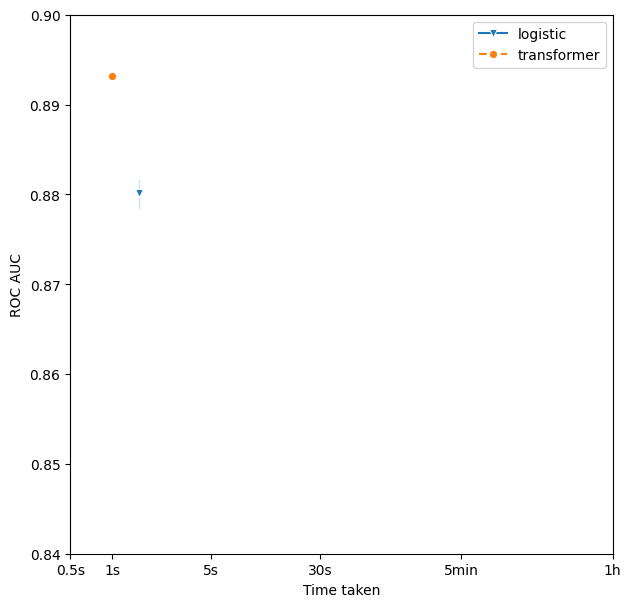

In [219]:
exclude=['']
#ax = make_tabular_results_plot('time', exclude=exclude)
ax = make_tabular_results_plot('roc', df_=df_absolute, exclude=exclude, grouping=False, max_times=[0.5, 1, 5, 30, 60*5, 60*60])
ax.set_ylim([0.84, 0.9])
ax.set_xlim([np.log10(0.5), np.log10(3600)])
#ax.legend([],[], frameon=False)


#tikzplotlib.save(f'roc_over_time.tex', axis_height='5cm', axis_width='6cm', strict=True)

    metricroc  real_time  time    method  split_number  metricrank_roc  \
5    0.879809   1.531824   0.5  logistic             1             NaN   
6    0.882274   1.531824   0.5  logistic             2             NaN   
7    0.876671   1.531824   0.5  logistic             3             NaN   
8    0.879959   1.531824   0.5  logistic             4             NaN   
9    0.882076   1.531824   0.5  logistic             5             NaN   
15        NaN   1.531824   0.5  logistic             1             1.5   
16        NaN   1.531824   0.5  logistic             2             1.5   
17        NaN   1.531824   0.5  logistic             3             1.5   
18        NaN   1.531824   0.5  logistic             4             1.5   
19        NaN   1.531824   0.5  logistic             5             1.5   
25        NaN   1.531824   0.5  logistic             1             NaN   
26        NaN   1.531824   0.5  logistic             2             NaN   
27        NaN   1.531824   0.5  logist

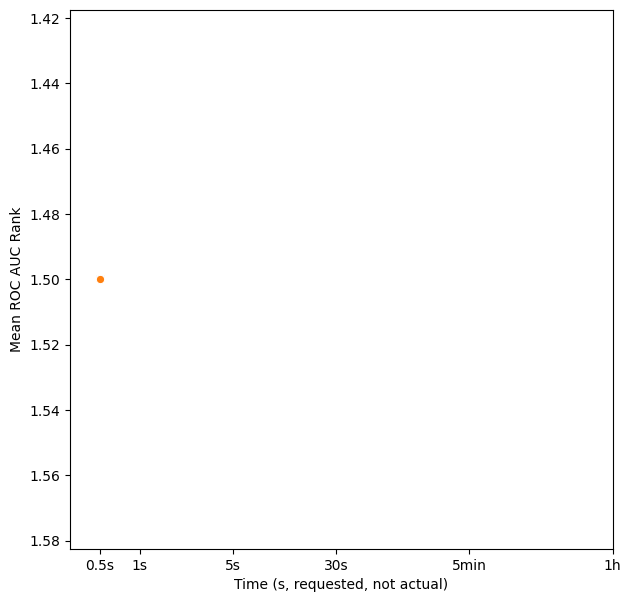

In [228]:
ax = make_tabular_results_plot('rank_roc', df_=df_[df_.time >= 0.4].copy(), exclude=['tabnet'], max_times=[0.5, 1, 5, 30, 60*5, 60*60])
ax.invert_yaxis()
ax.set_xlim([np.log10(0.3), np.log10(3600)])
ax.legend([],[], frameon=False)
#tikzplotlib.save(f'roc_raks_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

    metricroc  real_time  time    method  split_number  metricrank_roc  \
5    0.879809   1.531824   0.5  logistic             1             NaN   
6    0.882274   1.531824   0.5  logistic             2             NaN   
7    0.876671   1.531824   0.5  logistic             3             NaN   
8    0.879959   1.531824   0.5  logistic             4             NaN   
9    0.882076   1.531824   0.5  logistic             5             NaN   
15        NaN   1.531824   0.5  logistic             1             1.5   
16        NaN   1.531824   0.5  logistic             2             1.5   
17        NaN   1.531824   0.5  logistic             3             1.5   
18        NaN   1.531824   0.5  logistic             4             1.5   
19        NaN   1.531824   0.5  logistic             5             1.5   
25        NaN   1.531824   0.5  logistic             1             NaN   
26        NaN   1.531824   0.5  logistic             2             NaN   
27        NaN   1.531824   0.5  logist

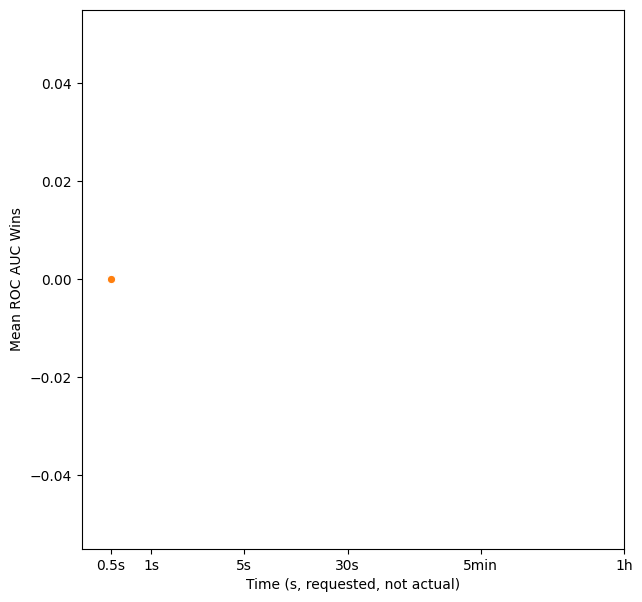

In [229]:
ax = make_tabular_results_plot('wins_roc', df_=df_[df_.time >= 0.4].copy(), exclude=exclude, max_times=[0.5, 1, 5, 30, 60*5, 60*60])
ax.set_xlim([np.log10(0.3), np.log10(3600)])
ax.legend([],[], frameon=False)
#tikzplotlib.save(f'roc_wins_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

#### Big Table metrics

In [230]:
max_time = '3600'

In [231]:
global_results_filtered = {**global_results}
global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}


In [244]:
#print(make_metric_matrix(global_results_filtered, methods, pos, 'roc', test_datasets))
roc_matrix, roc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'roc', test_datasets)#_filtered)
acc_matrix, acc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'acc', test_datasets)#_filtered)
cross_entropy_matrix, cross_entropy_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'cross_entropy', test_datasets)#_filtered)
time_matrix, time_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)#_filtered)

roc_rank, rocs_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())
cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())

In [245]:
def wins_vs_idx(matrix, idx):
    wins_auc = np.array([[(matrix.values[:, j] < matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    ties_auc = np.array([[(matrix.values[:, j] == matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    losses_auc = np.array([[(matrix.values[:, j] > matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    
    return wins_auc, ties_auc, losses_auc

transformer_idx = np.where(roc_matrix.columns == 'transformer')[0][0]

wins_roc_vs_us, ties_roc_vs_us, losses_roc_vs_us = wins_vs_idx(roc_matrix, transformer_idx)
wins_acc_vs_us, ties_acc_vs_us, losses_acc_vs_us = wins_vs_idx(acc_matrix, transformer_idx)
wins_ce_vs_us, ties_ce_vs_us, losses_ce_vs_us = wins_vs_idx(-cross_entropy_matrix, transformer_idx)

In [246]:
def rename(table):
    return table.rename(columns=relabeler).T.rename(columns={'blood-transfusion-service-center': 'blood-transfus..'
                                                                , 'jungle_chess_2pcs_raw_endgame_complete': 'jungle\_chess..', 'bank-marketing': 'bank-market..'}).T

def get_suffix(i, k):
    suffix = ''
    suffix = suffix+'s' if test_datasets[i][5]['samples_capped'] == True else suffix
    suffix = suffix+'f' if test_datasets[i][5]['feats_capped'] == True else suffix
    suffix = suffix+'c' if test_datasets[i][5]['classes_capped'] == True else suffix
    suffix = '' if len(suffix) == 0 else f' [{suffix}]'
    
    return k + suffix

<>:3: DeprecationWarning: invalid escape sequence \_
<>:3: DeprecationWarning: invalid escape sequence \_
<>:3: DeprecationWarning: invalid escape sequence \_
/var/folders/16/hwmpxdxd4hs0gcjgnlw_p8800000gn/T/ipykernel_37604/139613581.py:3: DeprecationWarning: invalid escape sequence \_
  , 'jungle_chess_2pcs_raw_endgame_complete': 'jungle\_chess..', 'bank-marketing': 'bank-market..'}).T


In [247]:
relabeler = {'transformer': 'Tabular PFN'
             , 'autogluon': 'Autogluon'
             , 'autosklearn2': 'Autosklearn2'
             , 'gp': 'GP (RBF)'
             , 'logistic': 'Log. Regr.'
             , 'knn': 'KNN'
             , 'catboost': 'Catboost'
            , 'xgb': 'XGB'}

In [292]:
table = roc_matrix.copy()
#table = roc_ovr_matrix.copy()
#table = acc_matrix.copy()
#table = cross_entropy_matrix.copy()

#table = table_acc
table.index = [get_suffix(i, k) for i, k in enumerate(table.index[0:table.shape[0]])]

table.loc['Wins AUC OVO'] = rocs_wins.values
#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Wins Acc.'] = acc_wins.values
#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Wins CE'] = cross_entropy_wins.values
table = table.fillna(0)

print(table)


                                  transformer  logistic
balance-scale                        0.996911       0.0
mfeat-fourier                        0.980081       0.0
breast-w                             0.993417       0.0
mfeat-karhunen                       0.997788       0.0
mfeat-morphological                  0.965225       0.0
mfeat-zernike                        0.981257       0.0
cmc                                  0.726031       0.0
credit-approval                      0.931590       0.0
credit-g                             0.789670       0.0
diabetes                             0.840872       0.0
tic-tac-toe                          0.962248       0.0
vehicle                              0.958669       0.0
eucalyptus                           0.923973       0.0
analcatdata_authorship               0.999988       0.0
analcatdata_dmft                     0.576630       0.0
pc4                                  0.936109       0.0
pc3                                  0.835707   

In [293]:
table.loc['Win/T/L AUC vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_roc_vs_us[-1, :], ties_roc_vs_us[-1, :], losses_roc_vs_us[-1, :])]
table.loc['Win/T/L Acc vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_acc_vs_us[-1, :], ties_acc_vs_us[-1, :], losses_acc_vs_us[-1, :])]
table.loc['Win/T/L CE vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_ce_vs_us[-1, :], ties_ce_vs_us[-1, :], losses_ce_vs_us[-1, :])]

table.loc['Mean AUC OVO'] = roc_matrix.mean(skipna=True)
table.loc['Mean AUC OVO Stds'] = roc_matrix_stds.mean(skipna=True)

#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Mean Acc.'] = acc_matrix.mean()
table.loc['Mean Acc. Stds'] = acc_matrix_stds.mean(skipna=True)

#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Mean CE'] = cross_entropy_matrix.mean()
table.loc['Mean CE Stds'] = cross_entropy_matrix_stds.mean()

table.loc['M. rank AUC OVO'] = roc_rank.values
#table.loc['Mean rank AUC OVR'] = roc_ovr_rank.values
table.loc['Mean rank Acc.'] = acc_rank.values
#table.loc['Mean rank Bal. Acc.'] = balanced_acc_rank.values
table.loc['Mean rank CE'] = cross_entropy_rank.values


In [294]:
table.loc['Mean time (s)'] = time_matrix.mean()
table.loc['Mean time (s)', 'knn'] = 0.5
table.loc['Mean time (s)', 'logistic'] = 60


In [295]:
#table = table[['knn', 'logistic', 'gp', 'catboost', 'xgb', 'autosklearn2', 'autogluon', 'transformer']]
table = table[['logistic', 'transformer']]
print(table)


                                 logistic transformer
balance-scale                         0.0    0.996911
mfeat-fourier                         0.0    0.980081
breast-w                              0.0    0.993417
mfeat-karhunen                        0.0    0.997788
mfeat-morphological                   0.0    0.965225
mfeat-zernike                         0.0    0.981257
cmc                                   0.0    0.726031
credit-approval                       0.0     0.93159
credit-g                              0.0     0.78967
diabetes                              0.0    0.840872
tic-tac-toe                           0.0    0.962248
vehicle                               0.0    0.958669
eucalyptus                            0.0    0.923973
analcatdata_authorship                0.0    0.999988
analcatdata_dmft                      0.0     0.57663
pc4                                   0.0    0.936109
pc3                                   0.0    0.835707
kc2                         

In [296]:

rename(table).round(decimals=3).style.highlight_max(axis = 1, props= 'font-weight: bold;').format(precision=3)

,Log. Regr.,Tabular PFN
balance-scale,0.000,0.997
mfeat-fourier,0.000,0.980
breast-w,0.000,0.993
mfeat-karhunen,0.000,0.998
mfeat-morphological,0.000,0.965
mfeat-zernike,0.000,0.981
cmc,0.000,0.726
credit-approval,0.000,0.932
credit-g,0.000,0.790
diabetes,0.000,0.841


In [297]:
def bold_extreme_values(data, format_string="%.3g", max_=True):
    data = data.astype(float).round(3)
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

def to_str(data, format_string="%.3g"):
    formatted = data.apply(lambda x : format_string % x)
    return formatted

In [298]:
keys_max = ["Mean rank CE", "Mean rank Acc.", "Mean rank AUC OVO", "Mean rank AUC OVR", "Mean rank Bal. Acc.", "Mean AUC OVO", "Mean Acc."]
keys_max = ["Mean AUC OVO", "Mean Acc.", "Wins AUC OVO", "Wins Acc.", "Wins CE"]

keys_min = ["Mean rank CE", "Mean rank Acc.", "M. rank AUC OVO", "Mean CE"]

table_latex = rename(table).copy()

table_latex.iloc[0:30] = table_latex.iloc[0:30].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[["Mean time (s)"]] = table_latex.loc[["Mean time (s)"]].apply(lambda data : bold_extreme_values(data, format_string="%.4g", max_=False), axis=1)
table_latex.loc[keys_max] = table_latex.loc[keys_max].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[keys_min] = table_latex.loc[keys_min].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex.loc[['Mean CE Stds']] = table_latex.loc[['Mean CE Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
table_latex = table_latex.drop(['Mean CE Stds'])

table_latex.loc[['Mean Acc. Stds']] = table_latex.loc[['Mean Acc. Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
table_latex = table_latex.drop(['Mean Acc. Stds'])

table_latex.loc[['Mean AUC OVO Stds']] = table_latex.loc[['Mean AUC OVO Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean AUC OVO'] = table_latex.loc['Mean AUC OVO'] + '$\pm$' + table_latex.loc['Mean AUC OVO Stds']
table_latex = table_latex.drop(['Mean AUC OVO Stds'])

table_latex
#print(table_latex.to_latex(escape=False))

<>:14: DeprecationWarning: invalid escape sequence \p
<>:18: DeprecationWarning: invalid escape sequence \p
<>:22: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:18: DeprecationWarning: invalid escape sequence \p
<>:22: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:18: DeprecationWarning: invalid escape sequence \p
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/16/hwmpxdxd4hs0gcjgnlw_p8800000gn/T/ipykernel_37604/120379377.py:14: DeprecationWarning: invalid escape sequence \p
  table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
/var/folders/16/hwmpxdxd4hs0gcjgnlw_p8800000gn/T/ipykernel_37604/120379377.py:18: DeprecationWarning: invalid escape sequence \p
  table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
/var/folders/16/hwmpxdxd4hs0gcjgnlw_p8800000gn

,Log. Regr.,Tabular PFN
balance-scale,0,\textbf{0.997}
mfeat-fourier,0,\textbf{0.98}
breast-w,0,\textbf{0.993}
mfeat-karhunen,0,\textbf{0.998}
mfeat-morphological,0,\textbf{0.965}
mfeat-zernike,0,\textbf{0.981}
cmc,0,\textbf{0.726}
credit-approval,0,\textbf{0.932}
credit-g,0,\textbf{0.79}
diabetes,0,\textbf{0.841}


In [299]:
print(table_latex.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
{} &   Log. Regr. &               Tabular PFN \\
\midrule
balance-scale                    &            0 &            \textbf{0.997} \\
mfeat-fourier                    &            0 &             \textbf{0.98} \\
breast-w                         &            0 &            \textbf{0.993} \\
mfeat-karhunen                   &            0 &            \textbf{0.998} \\
mfeat-morphological              &            0 &            \textbf{0.965} \\
mfeat-zernike                    &            0 &            \textbf{0.981} \\
cmc                              &            0 &            \textbf{0.726} \\
credit-approval                  &            0 &            \textbf{0.932} \\
credit-g                         &            0 &             \textbf{0.79} \\
diabetes                         &            0 &            \textbf{0.841} \\
tic-tac-toe                      &            0 &            \textbf{0.962} \\
vehicle                          &         

In [300]:
table_latex_small = table_latex.iloc[-len(keys_min+keys_max)-1-3:]
table_latex_small

,Log. Regr.,Tabular PFN
Wins AUC OVO,0,\textbf{30}
Wins Acc.,0,\textbf{30}
Wins CE,0,\textbf{30}
Win/T/L AUC vs Us,0/0/0,0/0/0
Win/T/L Acc vs Us,0/0/0,0/0/0
Win/T/L CE vs Us,0/0/0,0/0/0
Mean AUC OVO,nan$\pm$nan,\textbf{0.893}$\pm$0.011
Mean Acc.,nan$\pm$nan,\textbf{0.823}$\pm$0.012
Mean CE,nan$\pm$nan,\textbf{0.736}$\pm$0.019
M. rank AUC OVO,2,\textbf{1}


In [301]:
print(table_latex_small.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
{} &   Log. Regr. &               Tabular PFN \\
\midrule
Wins AUC OVO      &            0 &               \textbf{30} \\
Wins Acc.         &            0 &               \textbf{30} \\
Wins CE           &            0 &               \textbf{30} \\
Win/T/L AUC vs Us &        0/0/0 &                     0/0/0 \\
Win/T/L Acc vs Us &        0/0/0 &                     0/0/0 \\
Win/T/L CE vs Us  &        0/0/0 &                     0/0/0 \\
Mean AUC OVO      &  nan$\pm$nan &  \textbf{0.893}$\pm$0.011 \\
Mean Acc.         &  nan$\pm$nan &  \textbf{0.823}$\pm$0.012 \\
Mean CE           &  nan$\pm$nan &  \textbf{0.736}$\pm$0.019 \\
M. rank AUC OVO   &            2 &                \textbf{1} \\
Mean rank Acc.    &            2 &                \textbf{1} \\
Mean rank CE      &            2 &                \textbf{1} \\
Mean time (s)     &           60 &             \textbf{3.94} \\
\bottomrule
\end{tabular}



In [307]:
table_latex = table.copy()
table_latex = table_latex.fillna(0)
print(table_latex)


                                 logistic transformer
balance-scale                         0.0    0.996911
mfeat-fourier                         0.0    0.980081
breast-w                              0.0    0.993417
mfeat-karhunen                        0.0    0.997788
mfeat-morphological                   0.0    0.965225
mfeat-zernike                         0.0    0.981257
cmc                                   0.0    0.726031
credit-approval                       0.0     0.93159
credit-g                              0.0     0.78967
diabetes                              0.0    0.840872
tic-tac-toe                           0.0    0.962248
vehicle                               0.0    0.958669
eucalyptus                            0.0    0.923973
analcatdata_authorship                0.0    0.999988
analcatdata_dmft                      0.0     0.57663
pc4                                   0.0    0.936109
pc3                                   0.0    0.835707
kc2                         

In [322]:
print(table_latex.shape)

table_latex = table_latex.replace('0/0/0',0)
print(table_latex[:-5])

table_latex.iloc[:-5] = table_latex.iloc[:-5].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.iloc[-5:-5] = table_latex.iloc[-5:-5].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex
#print(table_latex.to_latex(escape=False))

(46, 2)
                                  logistic  transformer
balance-scale                          0.0     0.996911
mfeat-fourier                          0.0     0.980081
breast-w                               0.0     0.993417
mfeat-karhunen                         0.0     0.997788
mfeat-morphological                    0.0     0.965225
mfeat-zernike                          0.0     0.981257
cmc                                    0.0     0.726031
credit-approval                        0.0     0.931590
credit-g                               0.0     0.789670
diabetes                               0.0     0.840872
tic-tac-toe                            0.0     0.962248
vehicle                                0.0     0.958669
eucalyptus                             0.0     0.923973
analcatdata_authorship                 0.0     0.999988
analcatdata_dmft                       0.0     0.576630
pc4                                    0.0     0.936109
pc3                                    0

,logistic,transformer
balance-scale,0,\textbf{0.997}
mfeat-fourier,0,\textbf{0.98}
breast-w,0,\textbf{0.993}
mfeat-karhunen,0,\textbf{0.998}
mfeat-morphological,0,\textbf{0.965}
mfeat-zernike,0,\textbf{0.981}
cmc,0,\textbf{0.726}
credit-approval,0,\textbf{0.932}
credit-g,0,\textbf{0.79}
diabetes,0,\textbf{0.841}


In [323]:
rename(table[-7:]).round(decimals=3).style.highlight_min(axis = 1, props= 'font-weight: bold;').format(precision=3)

,Log. Regr.,Tabular PFN
Mean Acc. Stds,nan,0.012
Mean CE,nan,0.736
Mean CE Stds,nan,0.019
M. rank AUC OVO,2.000,1.000
Mean rank Acc.,2.000,1.000
Mean rank CE,2.000,1.000
Mean time (s),60,3.940
